### Implementing XOR with PyTorch

XOR is a classic example of a binary decision function in computer science. It is well-known to not be linearly separable, so in the context of machine learning it is often presented as an early motivation for introducing nonlinear activation functions. In this notebook, we will explore the implementation of XOR in greater detail.

In [303]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

First, we will create our dataset. Since XOR is a function mapping $\{0,1\}^2 \to \{0,1\}$, we can fully specify the inputs and corresponding outputs.

In [304]:
X = torch.tensor([[0.,0.],[1.,0.],[0.,1.],[1.,1.]])
y = torch.tensor([[0.],[1.],[1.],[0.]])

## Case 1: ReLU Activation

We start by defining a feedforward neural network with a ReLU activation function and one hidden layer. How many nodes do we need in the hidden layer to properly learn XOR? We treat the width of the hidden layer as a hyperparameter, so it is convenient to implement the defining of the network as a function.

In [327]:
def relu_net(width):
    # Fixing the seed for PyTorch in the interest of reproducibility.
    torch.manual_seed(123);
    
    return torch.nn.Sequential(
        torch.nn.Linear(2, width),
        torch.nn.ReLU(),
        torch.nn.Linear(width,1)
    )

We now define a learning function that takes as input the training set, testing set, and model, with optional inputs for the learning rate and number of epochs (taking momentum to be zero). This will not only find the weights but also produce learning curves.

In [386]:
# Default learning rate is 0.1, default epochs is 2000
def learnXOR(X_train, y_train, model,
             learning_rate = 0.1, num_epochs = 2000,
             loss_fn = torch.nn.BCEWithLogitsLoss(), make_plot = False):

    num_nodes = [layer for layer in model if isinstance(layer, torch.nn.Linear)][0].out_features
    
    losses_train = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())

        percent_current = (epoch+1)/num_epochs*100
        print(f"Current percentage: {percent_current:.2f}%", end='\r')
    
    if make_plot:
        plt.plot(losses_train, '.', label=f'width = {num_nodes}')
        plt.xlabel('Training Epoch')
        plt.ylabel('Loss')
        plt.legend()

    # Evaluation of the truth table for the learned function. Note that we must pass model output through sigmoid manually.
    # True corresponds to values above the decision threshold of 0.5, while False corresponds to those below.
    learned_function = torch.sigmoid(model(X)) > 0.5
    success_Q = (learned_function == y).all().item() # Will return True if and only if the learned function matches XOR
    
    return losses_train, success_Q

Now, let us run over a few cases for the width of the network and plot the corresponding learning curves.

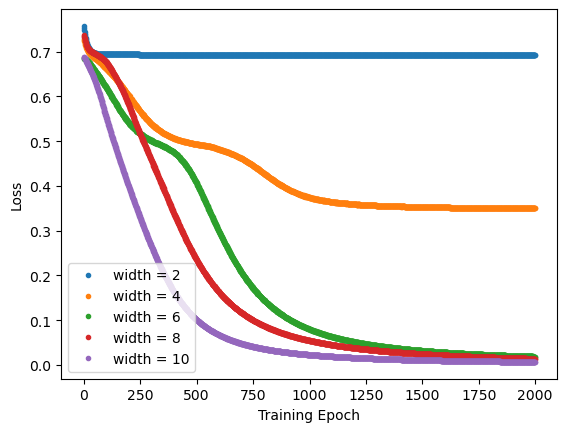

In [387]:
# We will use this list to track whether or not a model of a particular width successfully learns XOR.
track_success = []

for n in np.arange(2,11,2):
    relu_model = relu_net(n)
    _, success_Q = learnXOR(X, y, relu_model, make_plot = True)
    del relu_model
    track_success.append((n,success_Q))

plt.show()

These learning curves very clearly indicate that a width of 2 or 4 might be insufficient; we encounter vanishing gradients even though the loss has not reached zero. Higher widths, in contrast, avoid this problem, with the fastest approach to zero occurning for the largest width selected. However, for a large number of training epochs, we can also use a slightly smaller width if we wish.

We should also note that the cases where the loss does not reach zero correspond to a failure of the network to learn XOR.

In [388]:
print(track_success)

[(2, False), (4, False), (6, True), (8, True), (10, True)]


## Case 2: Tanh Activation

Let us now consider the tanh function instead of ReLU. Does this need a comparable width?

In [389]:
def tanh_net(width):
    # Fixing the seed for PyTorch in the interest of reproducibility.
    torch.manual_seed(123);
    
    return torch.nn.Sequential(
        torch.nn.Linear(2, width),
        torch.nn.Tanh(),
        torch.nn.Linear(width,1)
    )

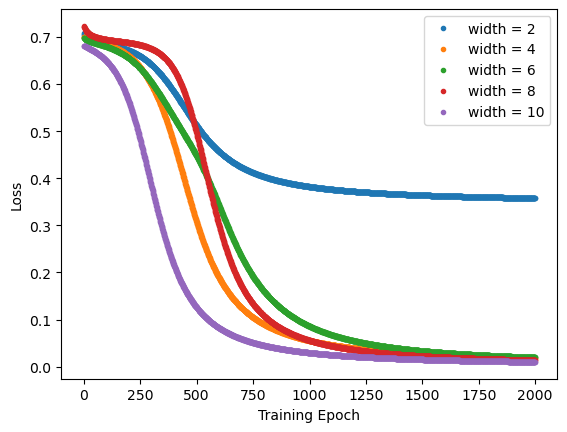

In [390]:
# We will use this list to track whether or not a model of a particular width successfully learns XOR.
track_success = []

for n in np.arange(2,11,2):
    tanh_model = tanh_net(n)
    _, success_Q = learnXOR(X, y, tanh_model, make_plot = True)
    del tanh_model
    track_success.append((n,success_Q))

plt.show()

In [391]:
print(track_success)

[(2, False), (4, True), (6, True), (8, True), (10, True)]


In this case, it seems like the tanh network is able to do better at lower widths (namely, at a width of 4) than the ReLU network.

### Case 3: (Failure of) Linear Activation

A linear activation function should fail. Let us demonstrate this.

In [392]:
def lin_net(width):
    # Fixing the seed for PyTorch in the interest of reproducibility.
    torch.manual_seed(123);
    
    return torch.nn.Sequential(
        torch.nn.Linear(2, width),
        torch.nn.Linear(width,1)
    )

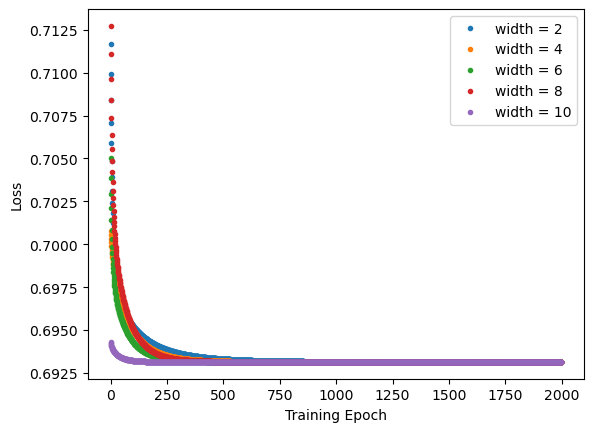

In [393]:
# We will use this list to track whether or not a model of a particular width successfully learns XOR.
track_success = []

for n in np.arange(2,11,2):
    lin_model = lin_net(n)
    _, success_Q = learnXOR(X, y, lin_model, make_plot = True)
    del lin_model
    track_success.append((n,success_Q))

plt.show()

The training curves clearly never reach zero even for the largest widths! Furthermore, the network completely fails to learn XOR.

In [394]:
print(track_success)

[(2, False), (4, False), (6, False), (8, False), (10, False)]
